In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crab-age-prediction/CrabAgePrediction.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='talk', style='darkgrid', font='MS GOTHIC')

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # Classifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [4]:
df = pd.read_csv('/kaggle/input/crab-age-prediction/CrabAgePrediction.csv')
df.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [5]:
df.info() # 性別以外はNumericな特徴量

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


In [6]:
# 動作確認
for col in df.columns:
    # ユニーク値はカテゴリカル特徴量にのみ意味あるかも(数値特徴量は被ることはあまりないので)
    # print(f'{col}, >> {df[col].unique()}') # ユニーク値
    print(f'{col}, >> {df[col].nunique()}') # ユニーク値の種類
    print('='*20)

Sex, >> 3
Length, >> 134
Diameter, >> 111
Height, >> 51
Weight, >> 2343
Shucked Weight, >> 1482
Viscera Weight, >> 867
Shell Weight, >> 907
Age, >> 28


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

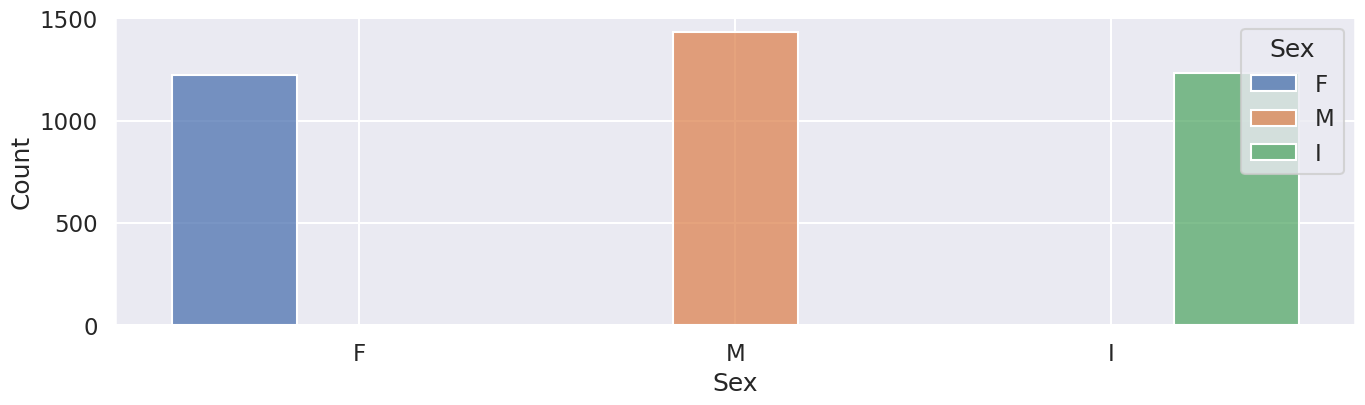

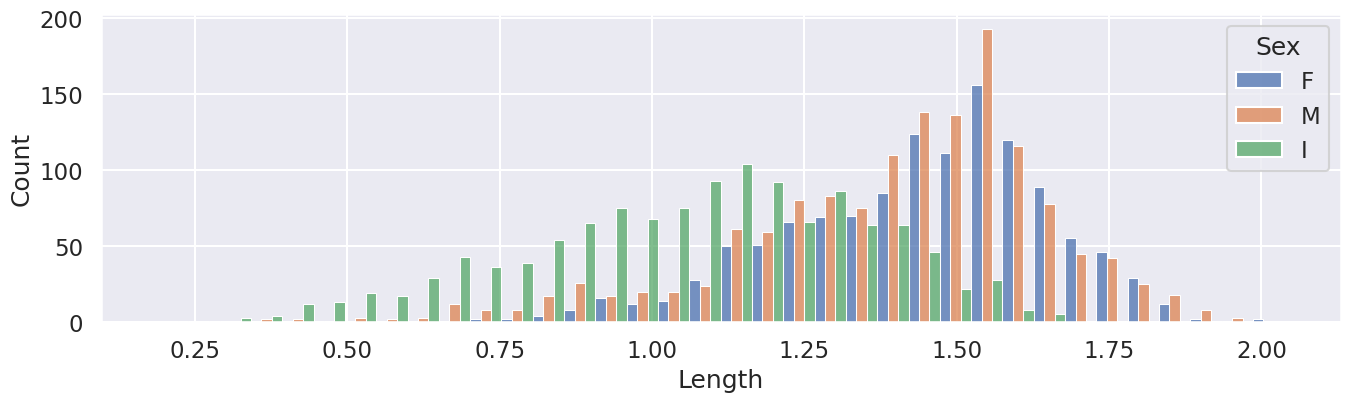

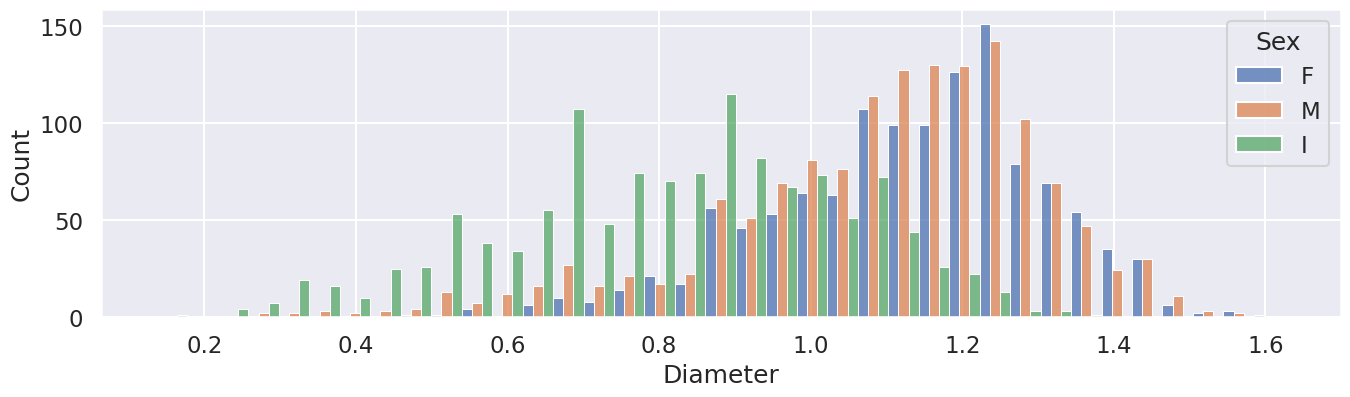

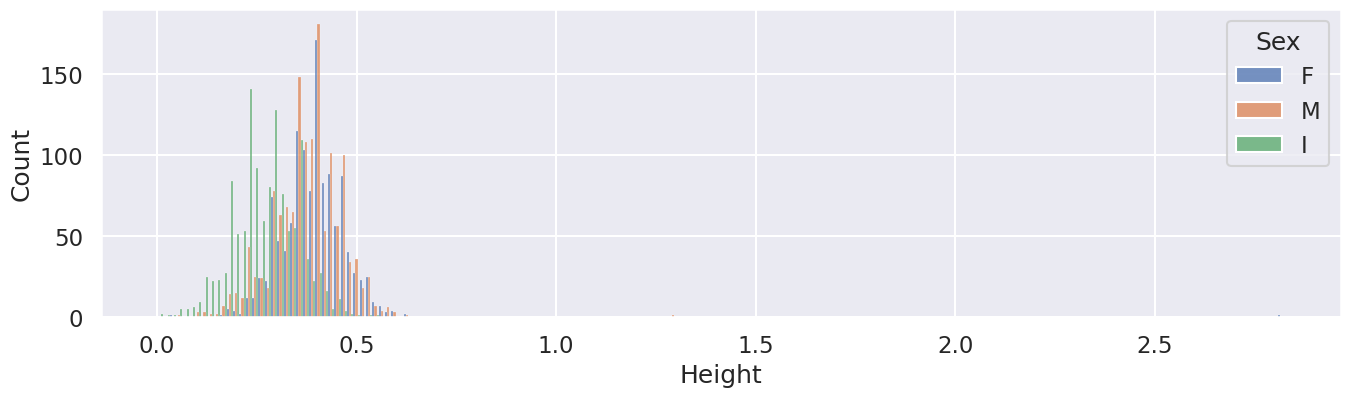

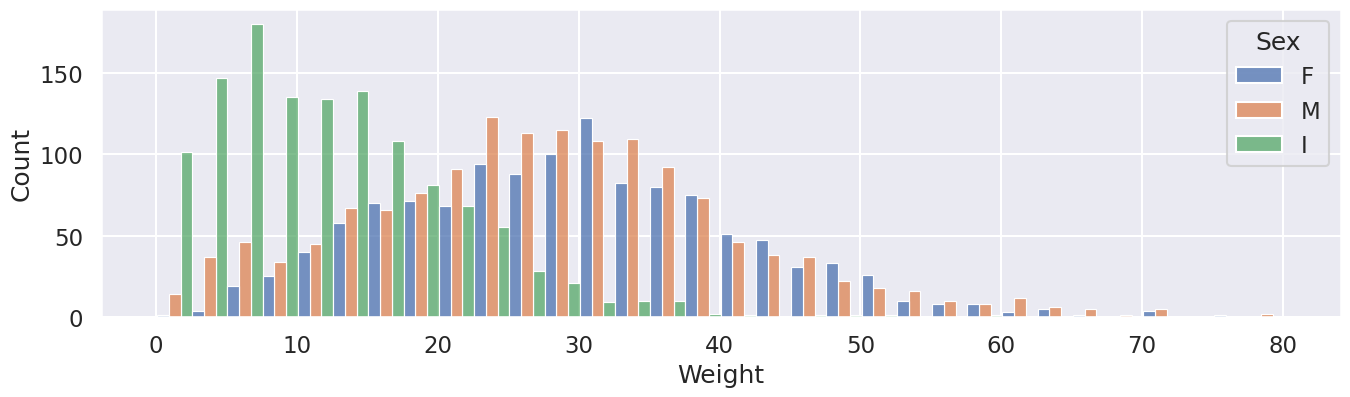

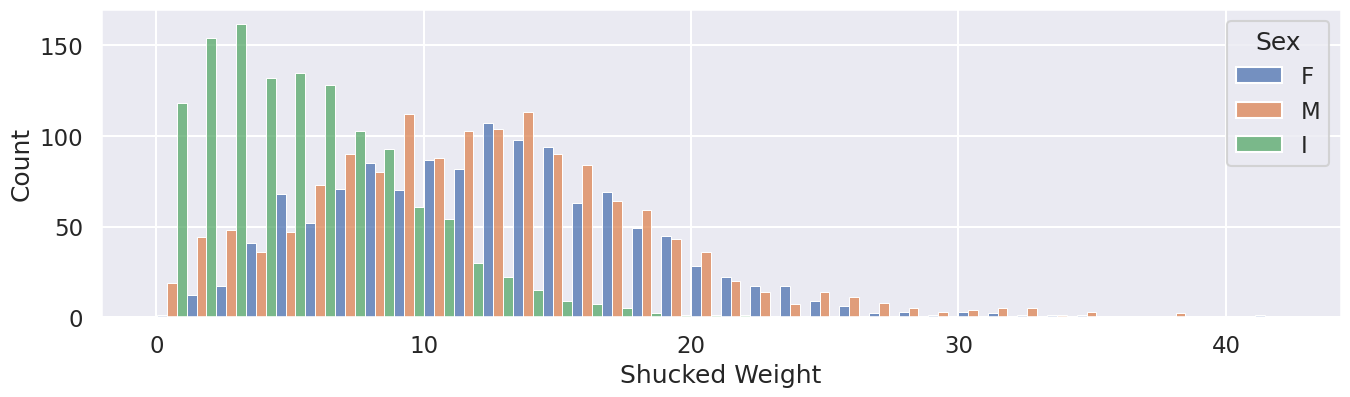

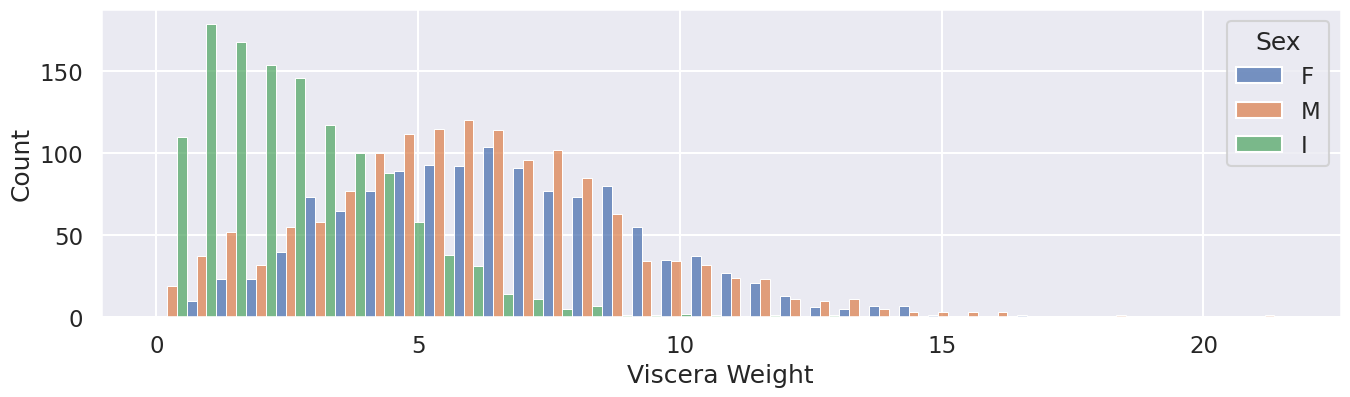

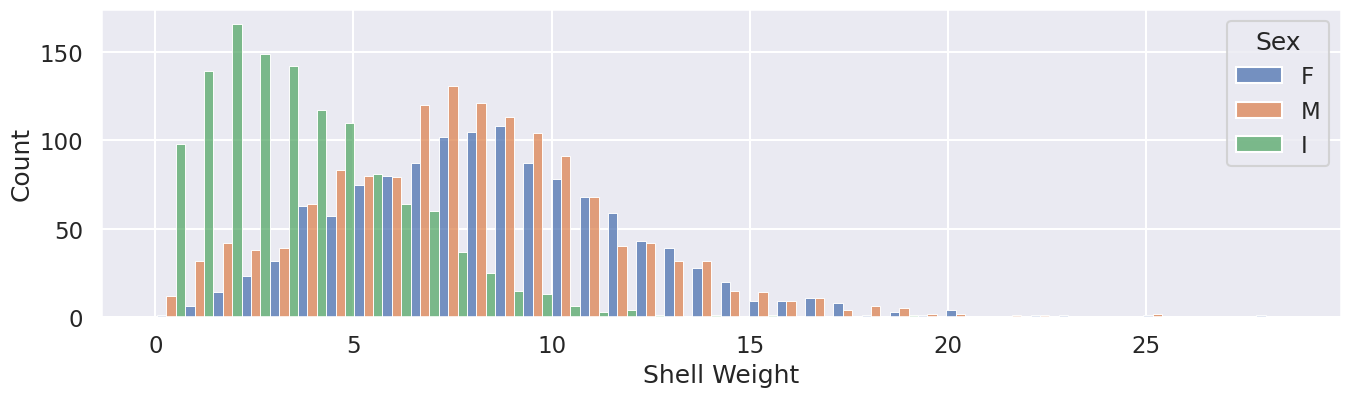

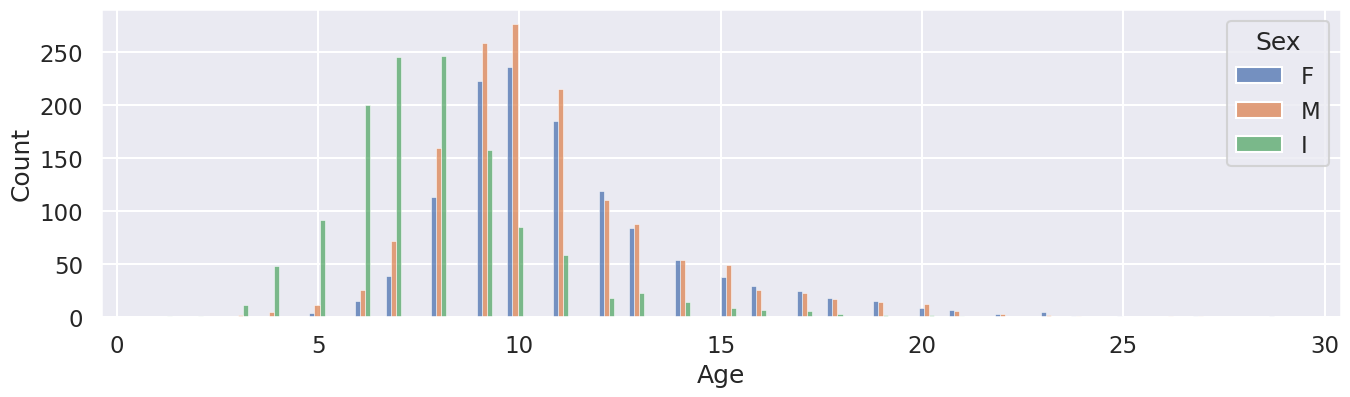

In [7]:
for col in df.columns:
    plt.figure(figsize=(16, 4))
    # sns.histplot(df[col])
    # sns.histplot(data=df, x=df[col])
    # hueにカテゴリカルな性別を指定
    # sns.histplot(data=df, x=df[col], hue='Sex')
    # 重ならないようにする
    sns.histplot(data=df, x=df[col], hue='Sex', multiple='dodge')
    # plt.show()

**気付き**
 - 性別の'I'は全ての特徴量で左側にある傾向がある
 - datasetのページを確認すると、　'I'は性別を判断できないもの

**Next Action**
 - 外れ値のあるHeightを確認

In [8]:
#　平均などの統計を確認
df['Height'].describe() # 平均や中央値に比べてmaxがかなり大きい(おそらく外れ値)

count    3893.000000
mean        0.349374
std         0.104976
min         0.000000
25%         0.287500
50%         0.362500
75%         0.412500
max         2.825000
Name: Height, dtype: float64

In [9]:
# 値の大きいものを5つ取得する
df['Height'].nlargest(5) # 上位二つがかなり大きいので外れ値とする

2256    2.8250
748     1.2875
772     0.6250
1485    0.6250
2588    0.6250
Name: Height, dtype: float64

In [10]:
# 動作確認
print(df['Height'][2256], df['Height'][748])

# 動作確認(なぜ同じ挙動？)
print(df.loc[2256], df.iloc[2256])

2.825 1.2875
Sex                       F
Length               1.1375
Diameter             0.8875
Height                2.825
Weight            16.839603
Shucked Weight     9.412034
Viscera Weight     3.288542
Shell Weight       3.784658
Age                       8
Name: 2256, dtype: object Sex                       F
Length               1.1375
Diameter             0.8875
Height                2.825
Weight            16.839603
Shucked Weight     9.412034
Viscera Weight     3.288542
Shell Weight       3.784658
Age                       8
Name: 2256, dtype: object


In [11]:
# 外れ値をdrop
df.drop(index=[2256, 748], inplace=True)
df.shape

(3891, 9)

**NumericとCategoricalな特徴量に分ける**

In [12]:
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')

In [13]:
cat_features = ['Sex']
num_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight']

**Numericな特徴量とAgeの相関関係を確認**

<Figure size 1600x400 with 0 Axes>

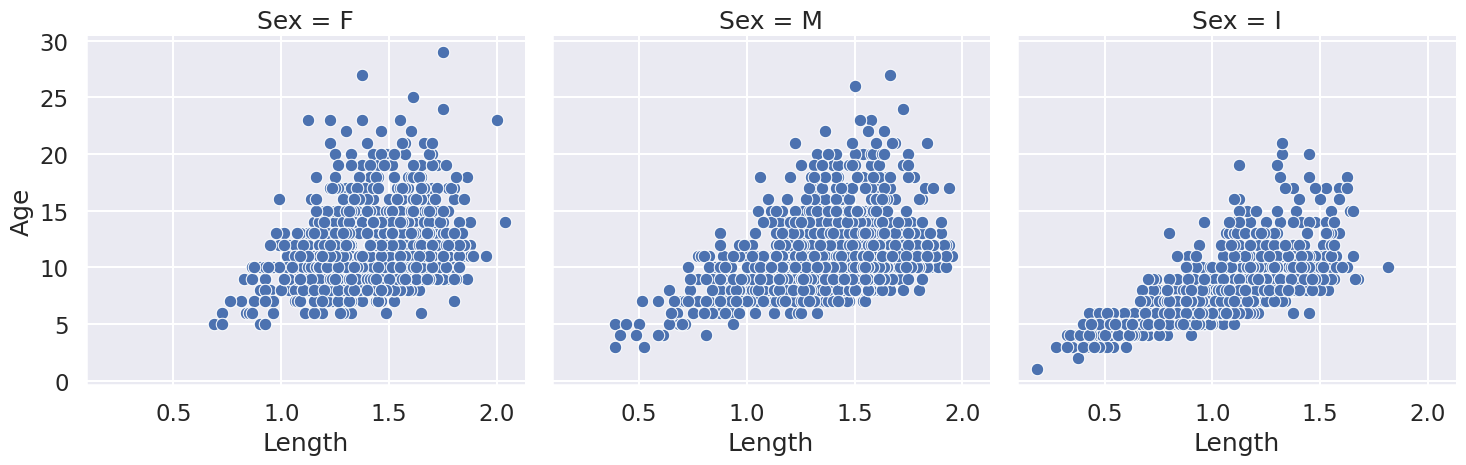

<Figure size 1600x400 with 0 Axes>

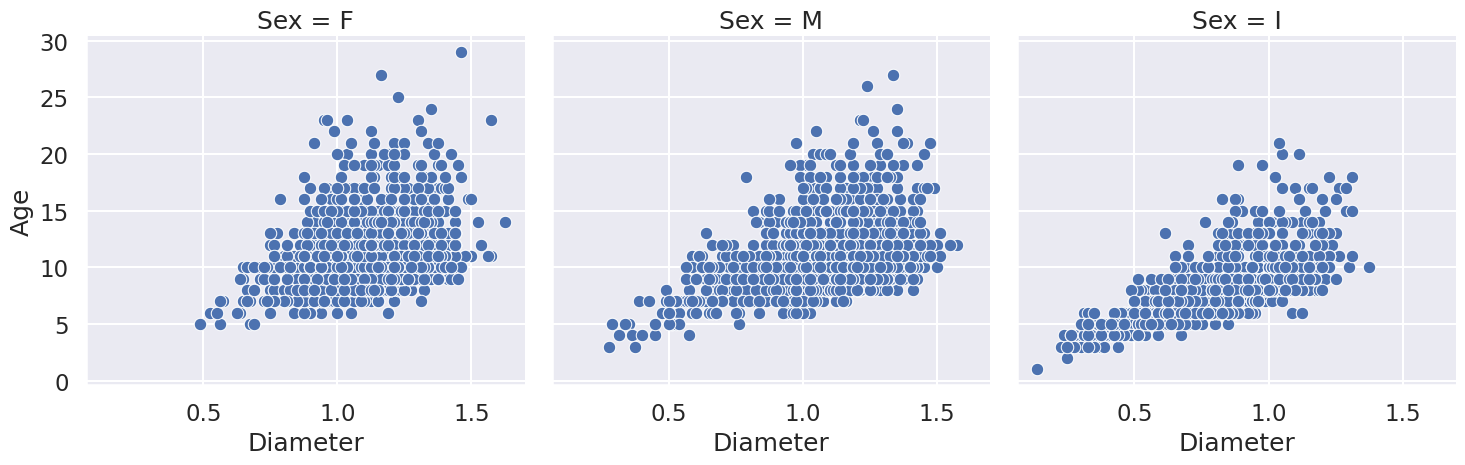

<Figure size 1600x400 with 0 Axes>

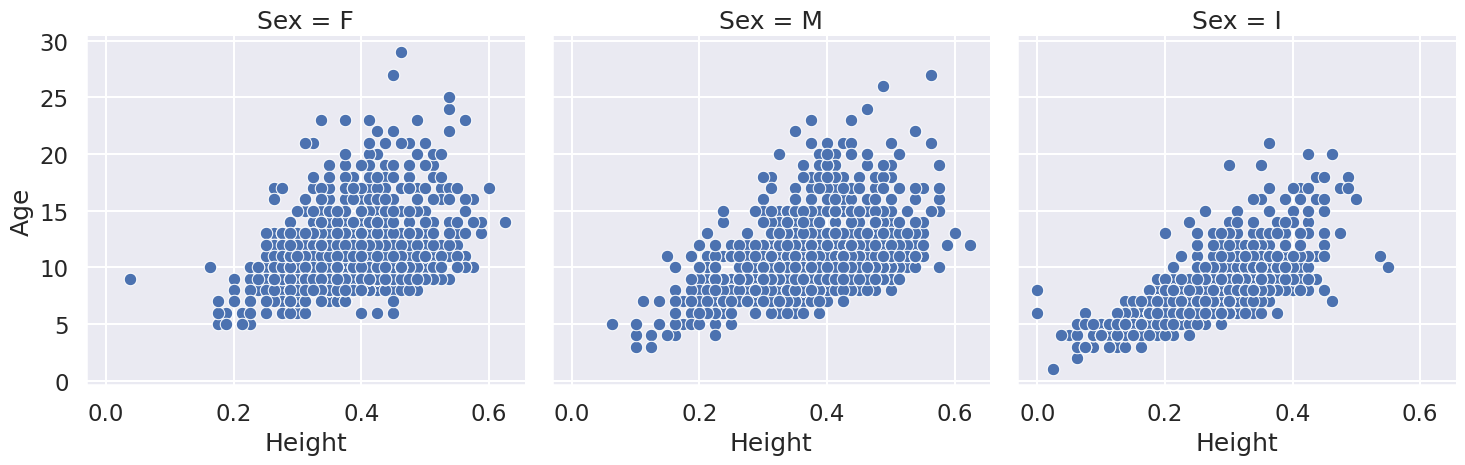

<Figure size 1600x400 with 0 Axes>

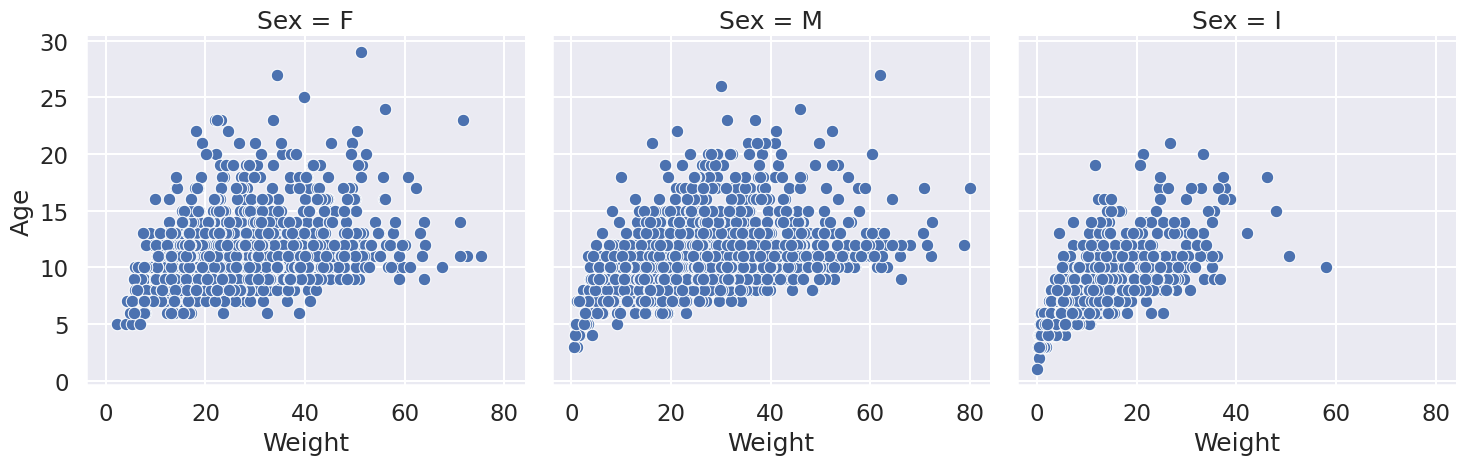

<Figure size 1600x400 with 0 Axes>

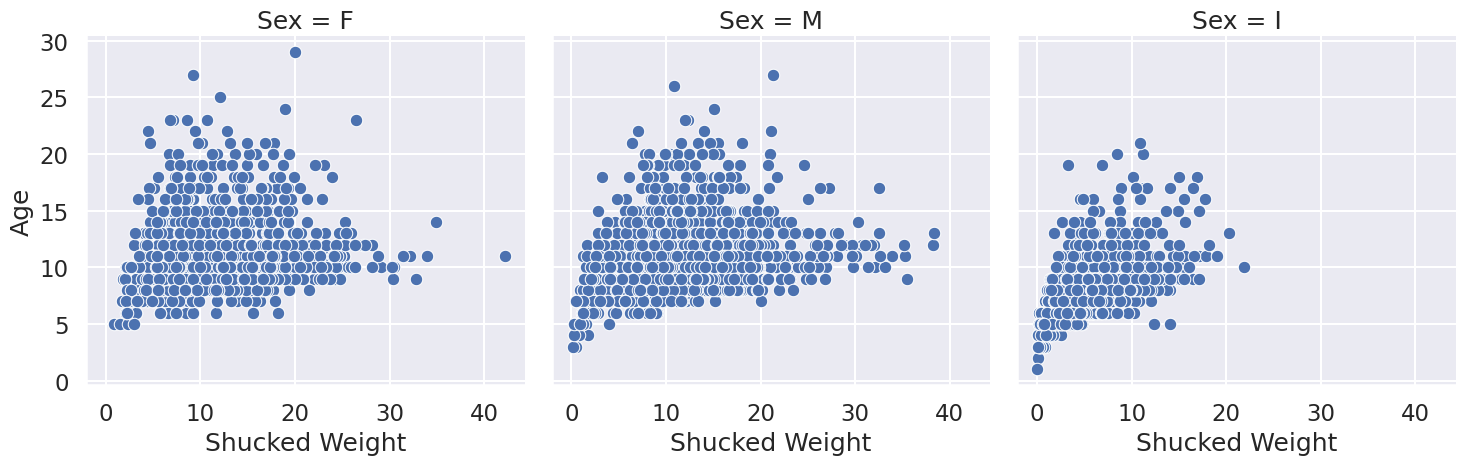

<Figure size 1600x400 with 0 Axes>

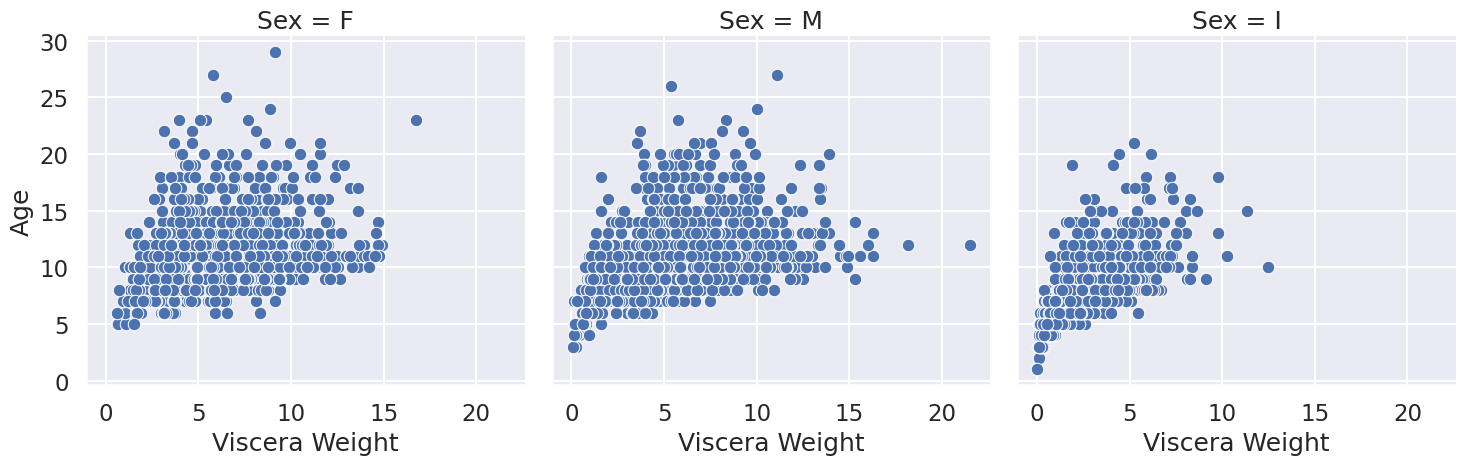

<Figure size 1600x400 with 0 Axes>

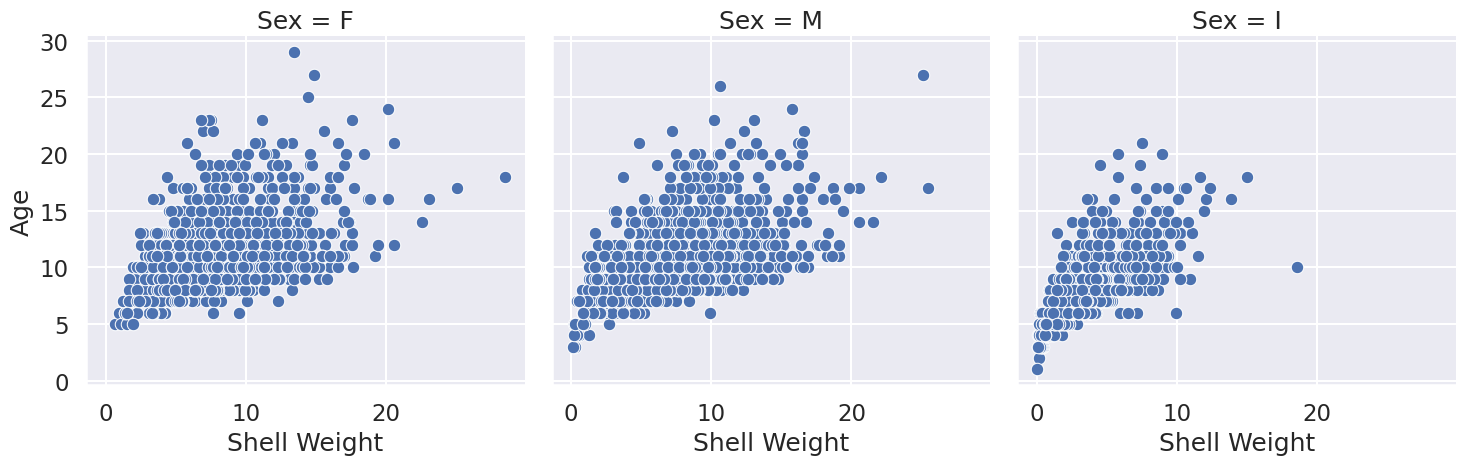

In [14]:
for feature in num_features:
    # print(feature)
    plt.figure(figsize=(16, 4))
    # A
    # sns.scatterplot(data=df, x=df[feature], y='Age')
    # sns.scatterplot(data=df, x=feature, y='Age') # こっちでも同じ挙動(おそらくdataにdfを指定しているので特徴量名だけでいい)
    # B (colごとのscatterplotを表示)
    sns.relplot(data=df, x=feature, y='Age', col='Sex')
    plt.show()

<Axes: >

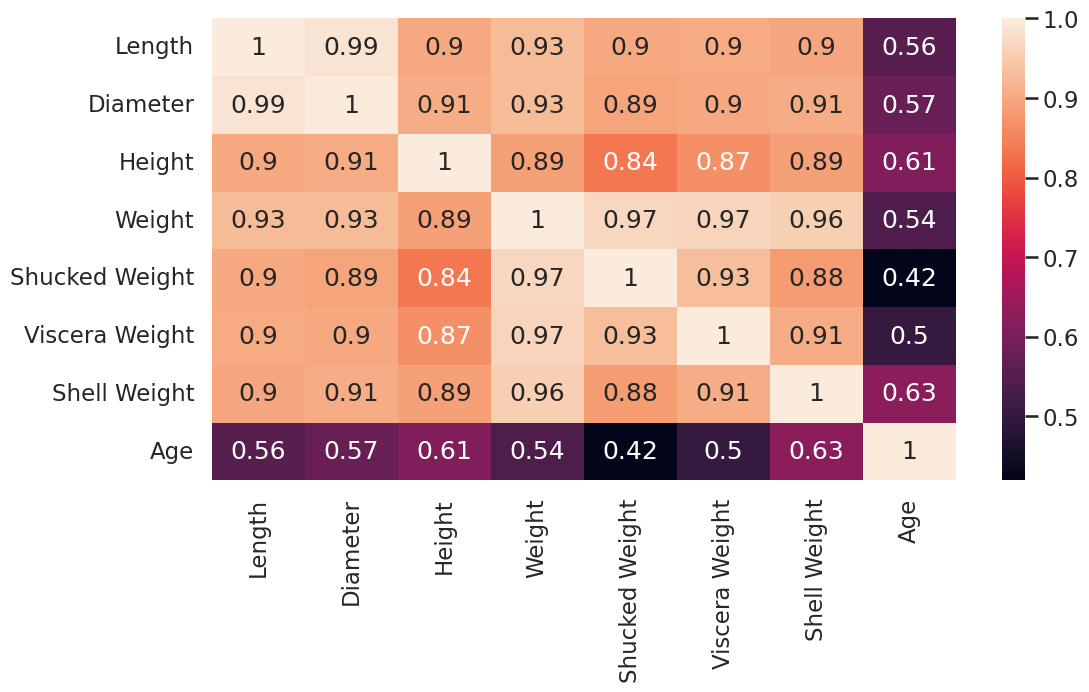

In [15]:
plt.figure(figsize=(12, 6))
# num_featuresはlist型なので、['Age']として追加し、目的変数との相関関係をヒートマップで可視化
sns.heatmap(df[num_features + ['Age']].corr(), annot=True)

**trainとtestに分割**

In [16]:
df_X = df.iloc[:, :-1] # 全てのサンプルでAgeの特徴量を除くデータ
df_y = df.iloc[:, -1] # 全てのサンプルのAgeの特徴量のみ

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, random_state=17, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3112, 8), (779, 8), (3112,), (779,))

**Categorical特徴量をOneHotベクトル化する**

In [17]:
encoder = OneHotEncoder(drop='first')
X_train_cat = encoder.fit_transform(X_train[['Sex']]) # trainデータをfitさせる
X_test_cat = encoder.transform(X_test[['Sex']]) # trainデータをfitさせたencoderでtestを変換する

**今回は偏りはあまりないが、Transformerを用いて正規分布に近づける(Numericな特徴量)**

In [18]:
transformer = QuantileTransformer(output_distribution='normal') # normal(正規分布)を指定...デフォルトではuniform(一様分布)
X_train_num = transformer.fit_transform(X_train.iloc[:, 1:]) # 一行目の性別以外のサンプルを指定
X_test_num = transformer.transform(X_test.iloc[:, 1:])

In [19]:
X_train_cat.toarray()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [20]:
X_train_num

array([[-0.38167465, -0.45008015, -0.67370246, ..., -0.41153446,
        -0.59843525, -0.54961629],
       [-1.14489597, -1.25574287, -1.33712701, ..., -1.21537205,
        -1.36845029, -1.22594275],
       [-2.16969406, -2.25674483, -2.08535557, ..., -2.31258051,
        -2.25674483, -2.27305239],
       ...,
       [ 1.00413133,  0.93779777,  0.76807531, ...,  1.27530247,
         1.49033514,  0.85167519],
       [-0.77314015, -0.91467864, -0.86801634, ..., -0.7413876 ,
        -0.89203836, -0.76470967],
       [-1.07744551, -1.04224674, -0.4279759 , ..., -0.77483284,
        -0.89953386, -1.09327227]])

In [21]:
X_train_num[:, 0].std() # 標準化されているか0列目を確認

# ほぼ1なのでされていることを確認

1.0049938917536136

**分割してそれぞれ前処理した特徴量を結合**

In [22]:
# axis=1方向...列(特徴量)方向に連結
X_train = np.concatenate([X_train_cat.toarray(), X_train_num], axis=1)
X_test = np.concatenate([X_test_cat.toarray(), X_test_num], axis=1)

**モデルの構築**

In [28]:
# 変換後の中身を確認
X_train[0] # index=2以降が変換されている

# index=1, 2は性別がOneHotにエンコードされているから2つ使っている。

array([ 1.        ,  0.        , -0.38167465, -0.45008015, -0.67370246,
       -0.54740906, -0.41153446, -0.59843525, -0.54961629])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


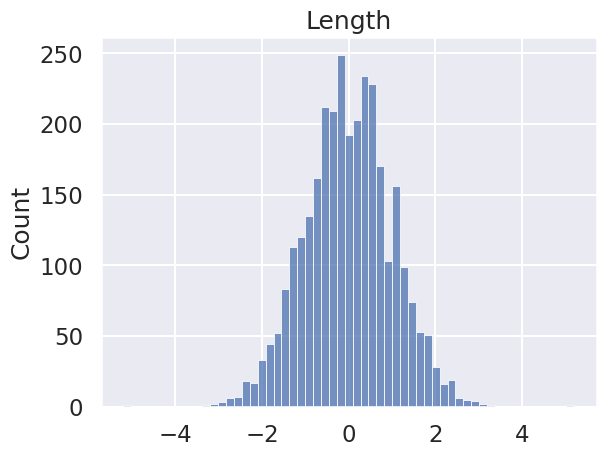

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


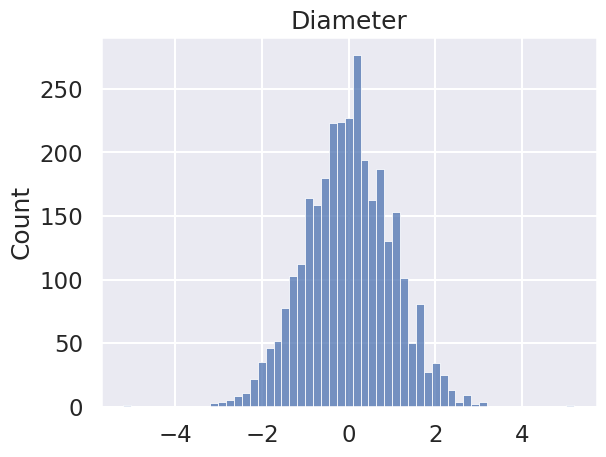

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


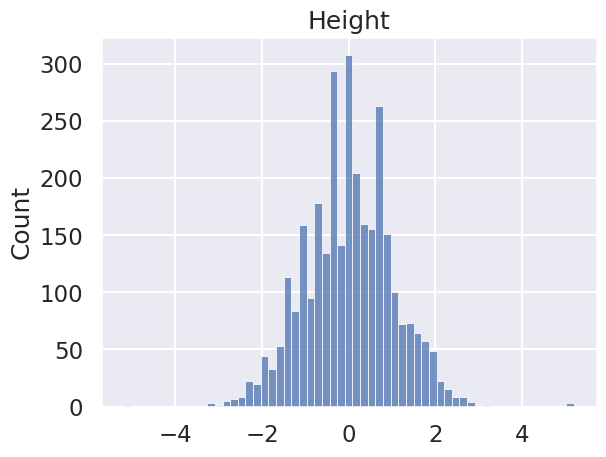

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


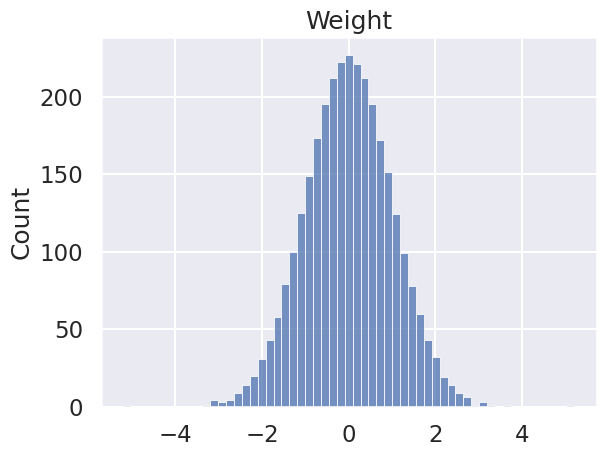

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


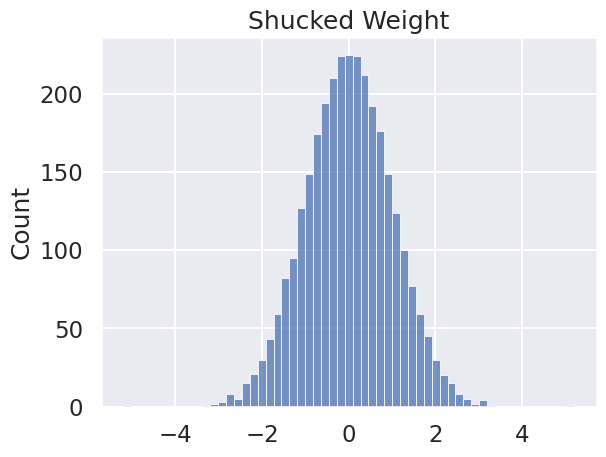

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


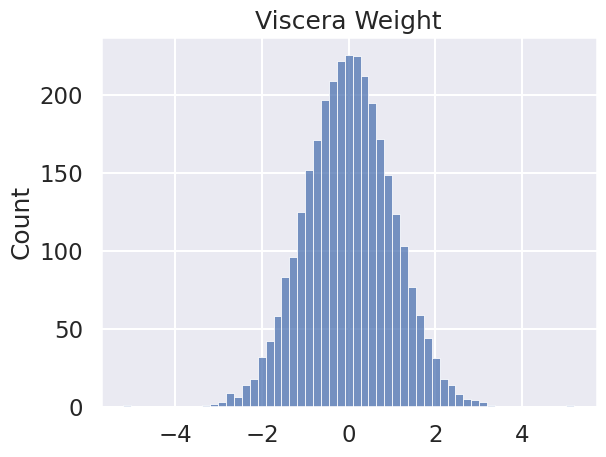

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


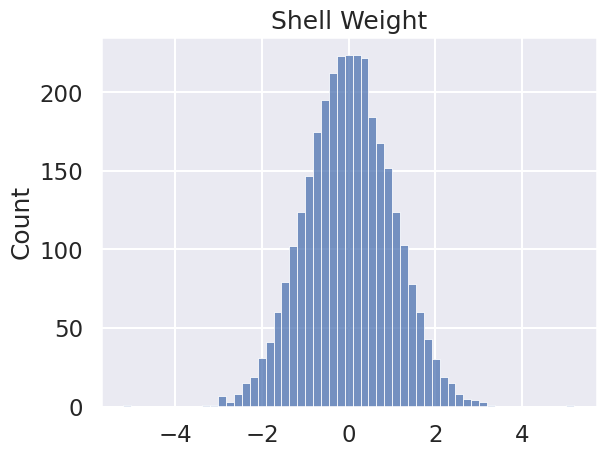

In [27]:
for i in range(2, len(X_train[0])):
    sns.histplot(X_train[:, i]) # 全てのサンプルで、特徴量は2番目から
    plt.title(df.columns[i-1]) # i=2の時、1になり、Lengthから始まる
    plt.show()

In [32]:
# モデルの作成
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=17)

In [33]:
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=17)

In [34]:
lr_model.score(X_test, y_test), rf_model.score(X_test, y_test)

(0.5389453230965517, 0.5407041443361359)

In [37]:
# ここでは代表してrfで確認
mae = mean_absolute_error(y_test, rf_model.predict(X_test))
mape = mean_absolute_percentage_error(y_test, rf_model.predict(X_test))

mae, mape

(1.5138125802310654, 0.15735685226132165)

In [41]:
# 実際の値と予測の値を結合して可視化
# 以下の書き方は何回かエラーを通して修正していけばいいので覚える必要はない
result = pd.DataFrame(
    np.concatenate([y_test.values.reshape(-1, 1), 
            rf_model.predict(X_test).reshape(-1, 1)], axis=1
    ), columns=['T', 'P'])
# y_testはSeries型なので、valuesでndarray型に変換し、それを2次元1列にreshapeしている

# axis=1で列方向に
# column名をTrue, Predictionにする

**見やすいようにソート**

In [44]:
# result
result.sort_values('T', inplace=True) # Trueでソート

In [49]:
# result
result.reset_index(drop=True, inplace=True) # indexを整理(drop=Trueで元のindexは削除)
result

,T,P
0,3.0,4.02
1,3.0,4.36
2,3.0,3.78
3,3.0,3.94
4,4.0,4.27
...,...,...
774,21.0,14.97
775,21.0,14.50
776,21.0,13.35
777,22.0,14.40


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

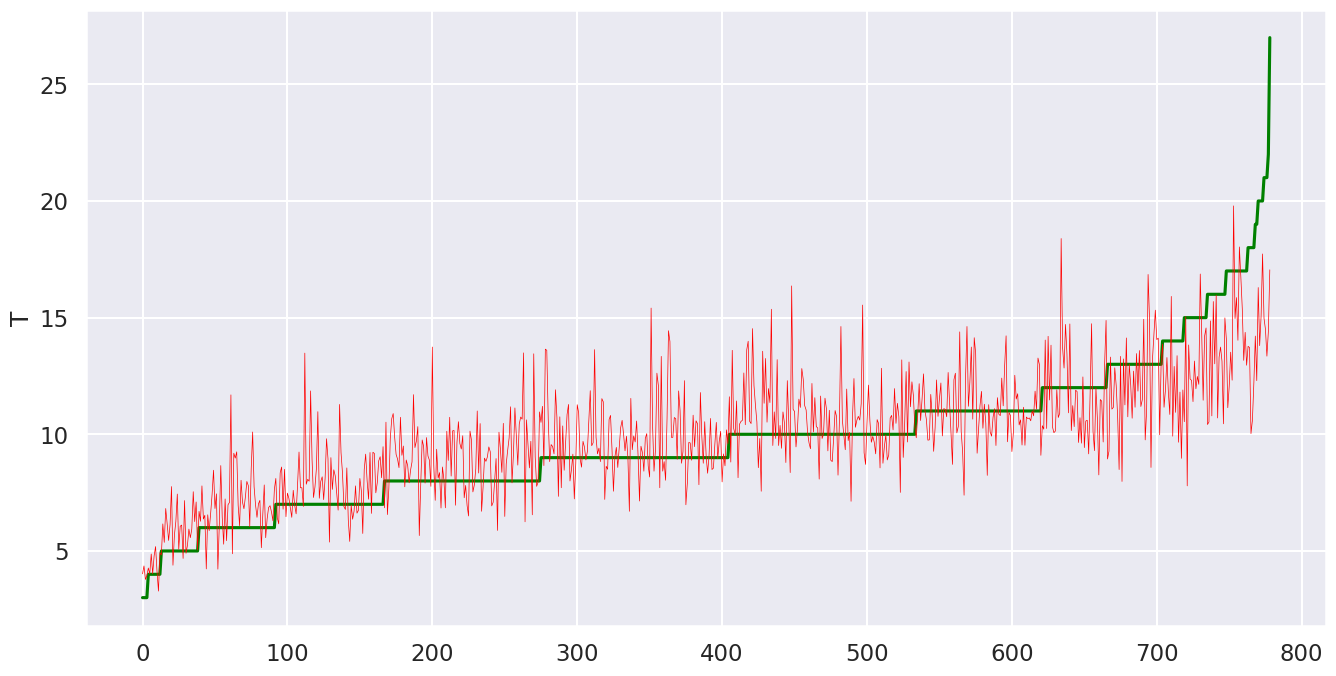

In [51]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=result.index, y=result['T'], color='green')
sns.lineplot(x=result.index, y=result['P'], color='red', linewidth=0.5)
plt.show()